# r/place2022 dataset analysis

r/place is an interactive project ran by Reddit for April Fools in 2017 and 2022.
It consists of a board of pixels that users can individually select and change the color of.

The 2017 board was 1000x1000 pixels and stayed open for 3 days.
The 2022 board started as 1000x1000 and had 2 expansions (to 1000x2000, then 2000x2000) and stayed open for 4 days.

[link to r/place timelapse](https://youtu.be/K5O3UgLG2Jw)

The [2022 official dataset](https://www.kaggle.com/datasets/antoinecarpentier/redditrplacecsv) explored in this notebook is a single file of 20.2 GiB 

The cluster setup used for this project defines two worker nodes that have:
- 4 cores each
- 16 GB of memory each

The configuration below reserves the following resources for the Spark application:
- 3 cores per executor, leaving 1 for running cluster manager daemons and the AMP
- 8 GB of memory per executor (YARN limitation)

Spark is also set to use the Kryo library for data serialization: Kryo serialization is faster and more compact than the default Java serialization.

In [1]:
%%configure -f
{"executorMemory":"8G", "numExecutors":2, "executorCores":3, 
 "conf": {"spark.dynamicAllocation.enabled": "false", 
          "spark.serializer": "org.apache.spark.serializer.KryoSerializer"}}

In [2]:
val bucketname = "unibo-bd2122-erughi"
val path_rplace = "s3a://"+bucketname+"/datasets/2022_place_canvas_history.csv"

"SPARK UI: Enable forwarding of port 20888 and connect to http://localhost:20888/proxy/" + sc.applicationId + "/"

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1667554385214_0001,spark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

bucketname: String = unibo-bd2122-erughi
path_rplace: String = s3a://unibo-bd2122-erughi/datasets/2022_place_canvas_history.csv
res2: String = SPARK UI: Enable forwarding of port 20888 and connect to http://localhost:20888/proxy/application_1667554385214_0001/


In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1667554385214_0001,spark,idle,Link,Link,None,✔


In [4]:
import org.apache.spark.HashPartitioner
import org.apache.spark.sql.SaveMode
import org.apache.spark.storage.StorageLevel
import java.time._
import java.time.format._
import java.time.temporal.ChronoField
import scala.math._

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.HashPartitioner
import org.apache.spark.sql.SaveMode
import org.apache.spark.storage.StorageLevel
import java.time._
import java.time.format._
import java.time.temporal.ChronoField
import scala.math._


## Tile Placement Data

The data is available as a CSV file with the following format:

**timestamp, userid, pixelcolor, coordinate**

- Timestamp - the UTC time of the tile placement
- Userid - a hashed identifier for each user placing the tile. These are not reddit userids, but instead a hashed identifier to allow correlating tiles placed by the same user.
- Pixel_color - the hex color code of the tile placed
- Coordinate - the “x,y” coordinate of the tile placement. 0,0 is the top left corner. 1999,0 is the top right corner. 0,1999 is the bottom left corner of the fully expanded canvas. 1999,1999 is the bottom right corner of the fully expanded canvas.

example row:<br>
2022-04-03 17:38:22.252 UTC,yTrYCd4LUpBn4rIyNXkkW2+Fac5cQHK2lsDpNghkq0oPu9o//8oPZPlLM4CXQeEIId7l011MbHcAaLyqfhSRoA==,#FF3881,"0,0"


## Parsing of the tiles

- timestamp, user_id and pixel_color - String
- coordinates - a tuple (x,y) and an optional tuple (x2,y2) for admin placements; (x2,y2) is the second point of the rectangle

In [5]:
// Tile(timestamp, user_id, pixel_color, (x,y))
object Tile {
  val commaRegex = ",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)"
  def extract(row:String) : Option[(String, String, String, (Int, Int))] = {    
    val columns = row.split(commaRegex)
    columns(3).replaceAll("\"","").split(",") match {
      case Array(x, y) => Some(columns(0),columns(1),columns(2),(x.toInt,y.toInt))
      case Array(x1,y1,x2,y2) => None // do not add admin placed tiles to rdd
      case _ => None
    }
  }
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defined object Tile


In [6]:
val rdd = sc.textFile(path_rplace).
                mapPartitionsWithIndex((i, iterator) => if (i == 0) iterator.drop(1) else iterator). // remove header (1st row)
                flatMap(Tile.extract)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rdd: org.apache.spark.rdd.RDD[(String, String, String, (Int, Int))] = MapPartitionsRDD[3] at flatMap at <console>:40


## Dataset exploration

- number of pixels placed : 160'353'085

---------------------------------------

- timestamp of first expansion  : 2022-04-02 16:24:56.239 UTC (coord (1007,491))
- timestamp of second expansion : 2022-04-03 19:03:53.356 UTC (coord (1338,1267))

---------------------------------------
- first timestamp : 2022-04-01 12:44:10.315 UTC
- last timestamp  : 2022-04-05 00:14:00.207 UTC
- experiment runtime : 83 hours

---------------------------------------

- most used colors in each phase
    - before 1st expansion -> 16 colors
    - after 1st expansion -> 24 colors
    - after 2nd expansion -> 32 colors

---------------------------------------

- number of unique users : 10'381'144
- most active users 
    - most pixels placed by a user: 795 = min 66.25 hrs of placing


In [18]:
val orderedTimesRdd = rdd.map({case(timestamp, _, _, coords) => (coords, timestamp)}).
    sortBy(x => x._2, true, 96).
    persist(StorageLevel.MEMORY_AND_DISK_SER) // 5.9GiB

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

orderedTimesRdd: org.apache.spark.rdd.RDD[((Int, Int), String)] = MapPartitionsRDD[61] at sortBy at <console>:37


In [19]:
// number of pixels placed
val nPixels = orderedTimesRdd.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

nPixels: Long = 160353085


In [20]:
val firstExpansionTime = orderedTimesRdd.filter(_._1._1 > 999).first()   // x > 999
val secondExpansionTime = orderedTimesRdd.filter(_._1._2 > 999).first()  // y > 999

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

firstExpansionTime: ((Int, Int), String) = ((1007,491),2022-04-02 16:24:56.239 UTC)
secondExpansionTime: ((Int, Int), String) = ((1338,1267),2022-04-03 19:03:53.356 UTC)


In [21]:
val f = new DateTimeFormatterBuilder().
    appendPattern("yyyy-MM-dd HH:mm:ss").
    appendFraction(ChronoField.MICRO_OF_SECOND, 0, 3, true).
    appendPattern(" zzz").
    toFormatter()

val firstTime = orderedTimesRdd.map({case(_, timestamp) => (timestamp)}).min()
val lastTime = orderedTimesRdd.map({case(_, timestamp) => (timestamp)}).max()
val totTime = Duration.between(LocalDateTime.parse(firstTime, f), LocalDateTime.parse(lastTime, f)).toHours

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

f: java.time.format.DateTimeFormatter = Value(YearOfEra,4,19,EXCEEDS_PAD)'-'Value(MonthOfYear,2)'-'Value(DayOfMonth,2)' 'Value(HourOfDay,2)':'Value(MinuteOfHour,2)':'Value(SecondOfMinute,2)Fraction(MicroOfSecond,0,3,DecimalPoint)' 'ZoneText(SHORT)
firstTime: String = 2022-04-01 12:44:10.315 UTC
lastTime: String = 2022-04-05 00:14:00.207 UTC
totTime: Long = 83


In [22]:
orderedTimesRdd.unpersist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res35: orderedTimesRdd.type = MapPartitionsRDD[61] at sortBy at <console>:37


In [23]:
// most used colors

// before 1st expansion (16 colors)
rdd.
  map({case(timestamp, _, color, _) => (color, timestamp)}).
  filter(_._2 < firstExpansionTime._2).
  aggregateByKey(0, 1)((acc, v) => acc+1, (acc1, acc2) => acc1+acc2).
  toDF("color", "nPixels").write.option("header", true).format("csv").mode(SaveMode.Overwrite).
  save("s3a://"+bucketname+"/spark/rplace/colors0")

// after 1st expansion (24 colors)
rdd.
  map({case(timestamp, _, color, _) => (color, timestamp)}).
  filter(x => (x._2 >= firstExpansionTime._2) && (x._2 < secondExpansionTime._2)).
  aggregateByKey(0, 1)((acc, v) => acc+1, (acc1, acc2) => acc1+acc2).
  toDF("color", "nPixels").write.option("header", true).format("csv").mode(SaveMode.Overwrite).
  save("s3a://"+bucketname+"/spark/rplace/colors1")

// after 2nd expansion (32 colors)
rdd.
  map({case(timestamp, _, color, _) => (color, timestamp)}).
  filter(_._2 >= secondExpansionTime._2).
  aggregateByKey(0, 1)((acc, v) => acc+1, (acc1, acc2) => acc1+acc2).
  toDF("color", "nPixels").write.option("header", true).format("csv").mode(SaveMode.Overwrite).
  save("s3a://"+bucketname+"/spark/rplace/colors2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Most used colors

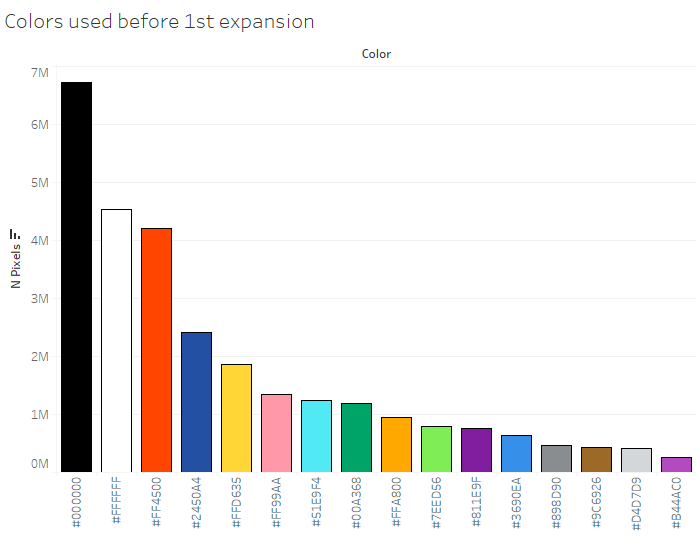

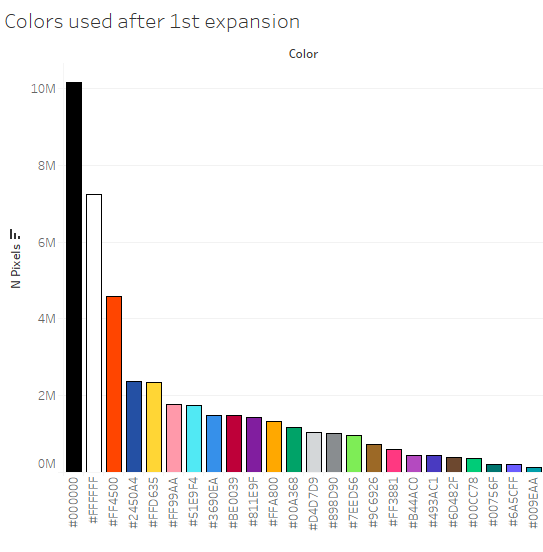

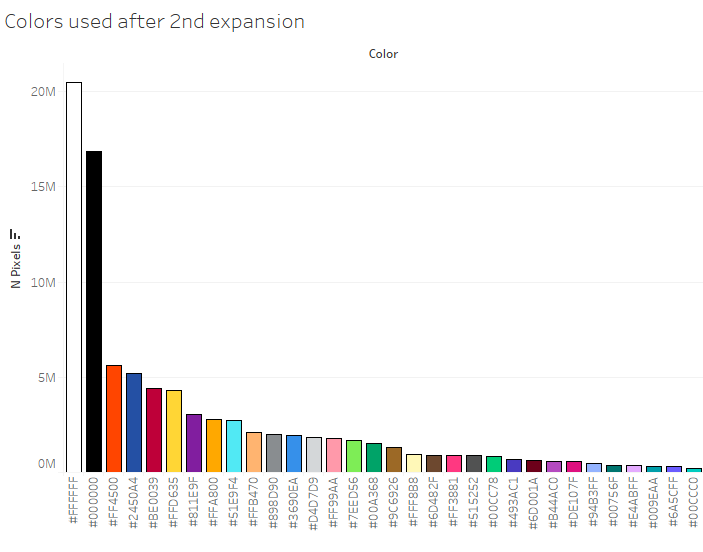

Observations:
- black is the most used color because it was used for outlines, backgrounds and, mainly, griefing
- in the last expansion white is most used because the experiment ended with white being the only available color
- red (summed to dark red in last expansion) always maintained a significant lead on the other colors
- notice that blue and yellow remained at 4th and 5th place throughout, probably because of the ukrainian flags (although blue and yellow are also present in many other flags, and flags dominated the board)

### Number of pixels placed each hour

In [24]:
//time chunks

// returns dd-HH from "yyyy-MM-dd HH:mm:ss" timestamp
def extractDayHour(timestamp:String): String = {
    val f = new DateTimeFormatterBuilder().
    appendPattern("yyyy-MM-dd HH:mm:ss").
    appendFraction(ChronoField.MICRO_OF_SECOND, 0, 3, true).
    appendPattern(" zzz").
    toFormatter()
    val dateTime = LocalDateTime.parse(timestamp, f)
    if (dateTime.getHour() < 10) dateTime.getDayOfMonth() + "-0" + dateTime.getHour()
    else dateTime.getDayOfMonth() + "-" + dateTime.getHour()
}

// number of pixels updated every hour
rdd.map(x => (extractDayHour(x._1), 1)).
    reduceByKey((_+_), 12).
    sortBy(x => x._1, true, 1). // 1 partition to write to 1 file
    toDF("dd-HH", "nPixels").write.option("header", true).format("csv").mode(SaveMode.Overwrite).
    save("s3a://"+bucketname+"/spark/rplace/activityPerHour")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

extractDayHour: (timestamp: String)String


Activity = number of pixels placed<br>

The graph exposes a cyclical pattern where the lowest activity registers at hour 07 (night in US and early morning in EU) and highest at hour 20/21 (afternoon in US and evening in EU).<br>

Overall activity increases the longer the experiment runs, thanks to articles, posts and videos being produced about the experiment.<br>

The increase in activity is also due to the board expansions, giving users more opportunity to create their pixel art.
- timestamp of first expansion  : 2022-04-02 16:24:56.239 UTC
    - activity was already increasing at this time, purely because of time of day, still there is an additional increase of activity to fill the newly added board space.
- timestamp of second expansion : 2022-04-03 19:03:53.356 UTC
    - again there is a spike in activity, this time of almost 1 million additional pixels placed

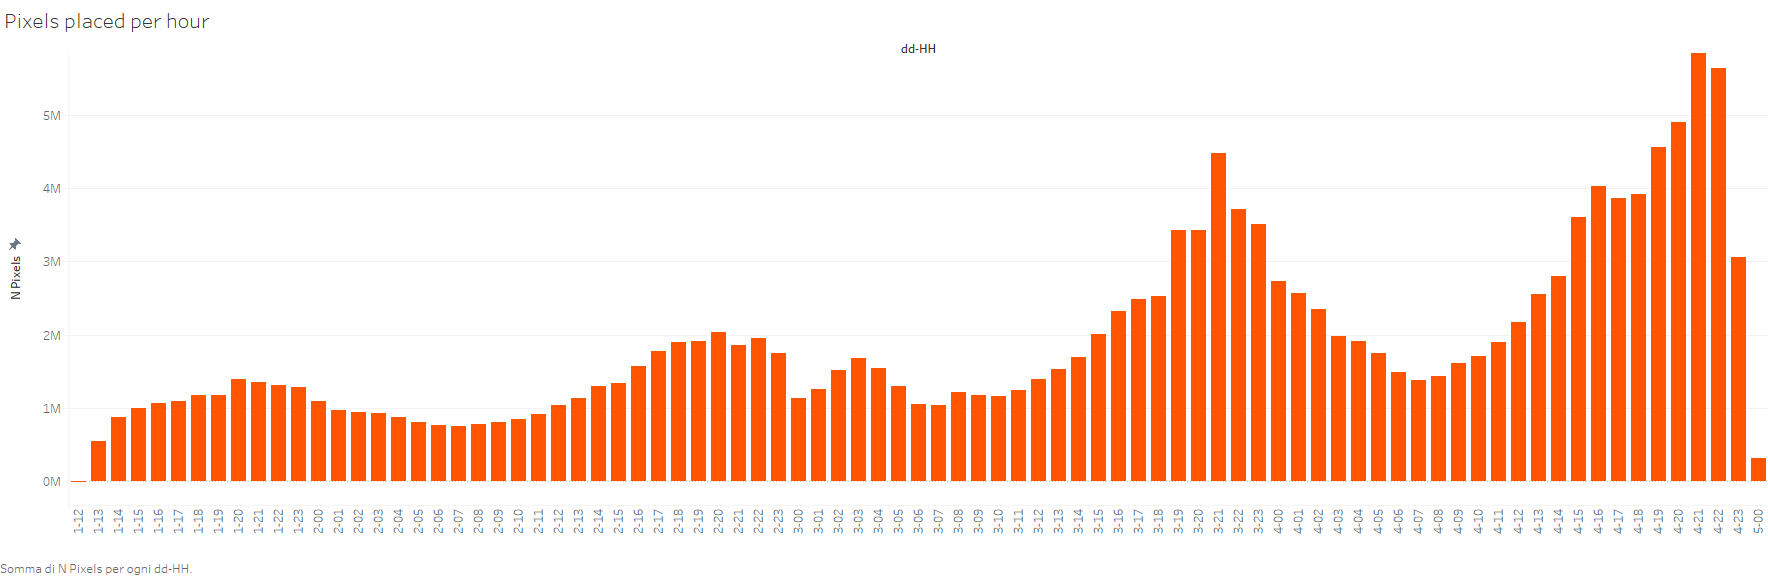

### User activity

In [7]:
val p = new HashPartitioner(36) // 36 ~= 2.4GiB / 64MiB

// count timestamps per user
val userActivityRdd = rdd.map({case(_, user, _, _) => (user, 1)}).  // shuffle write 11.7GiB
    reduceByKey(_+_, 186).
    partitionBy(p).
    cache()

// number of unique users
val nUsers = userActivityRdd.count()

//val nPixels = 160353085
"Number of pixels placed per user: " + (nPixels/nUsers)

// most active users
userActivityRdd.sortBy(_._2, false).values.take(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

p: org.apache.spark.HashPartitioner = org.apache.spark.HashPartitioner@24
userActivityRdd: org.apache.spark.rdd.RDD[(String, Int)] = ShuffledRDD[6] at partitionBy at <console>:41
nUsers: Long = 10381144
nPixels: Int = 160353085
res9: String = Number of pixels placed per user: 15
res12: Array[Int] = Array(795, 781, 777, 767, 767, 766, 765, 758, 730, 713)


## Detecting use of scripts

People quickly wrote scripts that would take a coordinate and an image: the coordinate would be used to correctly place the input image (desired outcome) within the actual board, thus allowing to detect "wrong" pixels. The script would place a pixel every 5 minutes (the placement cooldown) to eventually achieve the desired image.<br>

To identify a bot it is sufficient to count the streak of placements at 5 minute intervals; a high enough perfect streak is unlikely to have been made by a human. It is also necessary to allow a tolerance when detecting 5 minute intervals to account for network traffic and latency.<br> 

In the following code *botPixels* refers to pixels placed by scripts.

In [25]:
// transforms a timestamp string into milliseconds since Unix Epoch
def toMillis(timestamp:String): Long = {
    val f = new DateTimeFormatterBuilder().
    appendPattern("yyyy-MM-dd HH:mm:ss").
    appendFraction(ChronoField.MICRO_OF_SECOND, 0, 3, true).
    appendPattern(" zzz").
    toFormatter()
    val dateTime = LocalDateTime.parse(timestamp, f)
    dateTime.toInstant(ZoneOffset.UTC).toEpochMilli()
}

// treshold for how many consecutive placements are presumed to be made by bot
// i.e. 12 = 1h of consecutive placement, I presume a human wouldn't do that
val consecTreshold = 12

// milliseconds of tolerance for the 5 minute cooldown, 
// to account for script settings and network latency and traffic
val tolerance = 65000L // 65 seconds
// (found a script that placed every 5 and a half minutes, others had a 6 minute cooldown)

// checks for amount of consecutive placements exactly 5 min apart
// the input list of timestamps needs to be chronologically ordered
def checkBot(prevTime:Long, times:List[Long], counter:Int, totCount:Int): Int = {
    if(times.isEmpty) {
        if ( counter >= consecTreshold ) { totCount + counter }
        else totCount
    } else {
        if((times.head - prevTime) <= (300000+tolerance)) { // 300000ms = 5min
            checkBot(times.head, times.tail, counter+1, totCount)
        } else {
            if (counter >= consecTreshold ) { // add up consecutive bot placements
                checkBot(times.head, times.tail, 0, totCount + counter)
            } else {
                checkBot(times.head, times.tail, 0, totCount)
            }
        }
    }
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

toMillis: (timestamp: String)Long
consecTreshold: Int = 12
tolerance: Long = 65000
checkBot: (prevTime: Long, times: List[Long], counter: Int, totCount: Int)Int


### Optimizing bot detection

The following code has been optimized as follows:
- first it maps only the relevant columns of the RDD, *userHash* and *timestamp*, to reduce the amount of data to process
    - like all other operations that traverse the whole RDD, this operation is costly
    - while traversing the RDD it converts timestamps from their String format to milliseconds: the convertion from String to Long saves quite a bit of space, thus it's best to do it as soon as possible
- `groupByKey` is used to associate each *userHash* with an `Iterable[Long]` of all the user's pixel timestamps
    - since this operation involves shuffling data I took the opportunity to specify a partitioning into 222 partitions
        - the input size of 160 million (userHash, time) is 13.9GiB
        - 13.9GiB / 64MiB = 217.18 => 222 is a multiple of 6 (num of cores)
    - there is a 3s skewness, however it is noticeably faster than leaving default, smaller partitioning (~10s saved)
- for each user, their timestamps get sorted chronologically and fed to the `checkBot` function defined in the previous section in order to get the total number of pixels probably placed by a script<br>

This results in the following RDD : `RDD[(userHash, botPixels)]`

In [9]:
val botActivityRdd = rdd.
    map({case(timestamp, user, _, _) => (user, toMillis(timestamp))}). // after map it's 13.9GiB
    groupByKey(222). // partitions of 64MiB each, 37 partitions per core
    mapValues(x => {
      val t = x.toList.sorted
      checkBot(t.head, t.tail, 1, 0)
    }). // RDD[(userHash, Int)]
    partitionBy(p).
    cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

botActivityRdd: org.apache.spark.rdd.RDD[(String, Int)] = ShuffledRDD[16] at partitionBy at <console>:46


In [17]:
"Number of users who used scripts: " + botActivityRdd.filter(x => (x._2 > 1)).count
val nBotPixels = botActivityRdd.filter(x => (x._2 > 1)).values.reduce(_+_)
"Percentage of pixels placed by bots: " + ((nBotPixels.toFloat/nPixels)*100) + "%"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res31: String = Number of users who used scripts: 280528
nBotPixels: Int = 7506520
res32: String = Percentage of pixels placed by bots: 4.6812444%


### Exploring pixels placed by bots vs. overall placements

The following code seeks to explore the impact of script usage on the r/place experiment by comparing pixels placed by scripts vs total pixels placed. <br>

I expect that the more pixels a user placed, the more probable it is that a script was used.<br>

### Optimizations

- use of cached `userActivityRdd` previously calculated to get the top 10 users by activity (pixels placed)
- since both `userActivityRdd` and `botActivityRdd` benefit from being resized to a smaller number of partitions and both are of type RDD[(String, Int)] their partitioning was done using the same `HashPartitioner` so the join operation between the two RDDs is a *narrow dependency* => no further shuffling

## Analysis of user activity

I was interested in classifying users by the amout of pixels they placed, as I expect this information to reflect the different types of users who participated in the experiment: 
- casual visitor -> placed very few pixels at random times
- user took part in community projects
    - did not use scripts -> placed less than 100 pixels ( ~8hrs of consecutive placement )
    - used scripts for small amounts of time
    - used scripts for large amounts of time ( top user placed 795 pixels => ~66hrs of consecutive placement )
    
Thus in the code snippet below the RDD that resulted from the join operation contains all user hashes and, for each one, the number of pixels placed and the number of pixels presumed to have been placed with a script. <br> 
The users then get labeled based on the number of pixels they placed and users within the same range are merged together, thus getting the total number of pixels, total number of bot pixels and number of distinct users for each range.<br>

In [11]:
userActivityRdd.
    join(botActivityRdd).
    map({
        case(usr, (nPixels, botPixels)) if nPixels > 700 => (">700", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 601 to 700 contains nPixels => ("601-700", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 501 to 600 contains nPixels => ("501-600", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 401 to 500 contains nPixels => ("401-500", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 301 to 400 contains nPixels => ("301-400", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 201 to 300 contains nPixels => ("201-300", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 101 to 200 contains nPixels => ("101-200", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 1 to 100 contains nPixels => ("001-100", (nPixels, botPixels, 1))
    }).
    reduceByKey((x1,x2)=>(x1._1+x2._1, x1._2+x2._2, x1._3+x2._3)).
    sortBy(_._1, true, 1).
    flatMap({case(range, (nPixels, botPixels, nUsr)) => Array((range, nPixels, botPixels, nUsr))}).
    toDF("userActivity", "nPixels", "botPixels", "numUsers").
    write.option("header", true).format("csv").mode(SaveMode.Overwrite).
    save("s3a://"+bucketname+"/spark/rplace/userAndBotActivity100s")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Impact of high-activity users

The classic question of: is it better to have few big contributions or many small contributions?<br> As we can see here, the vast majority of pixels were placed by casual users.

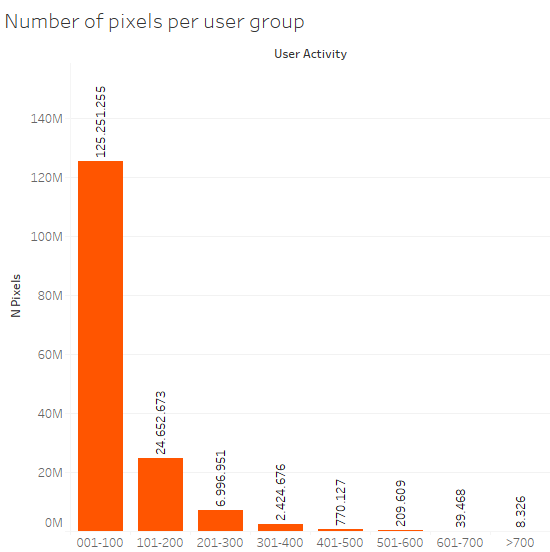
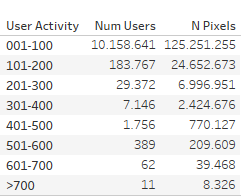

### Analysis of script usage

As previously calculated, the overall pecentage of pixels placed with scripts is 4.68%<br>
As expected, users that placed high numbers of pixels were more likely to have used scripts:
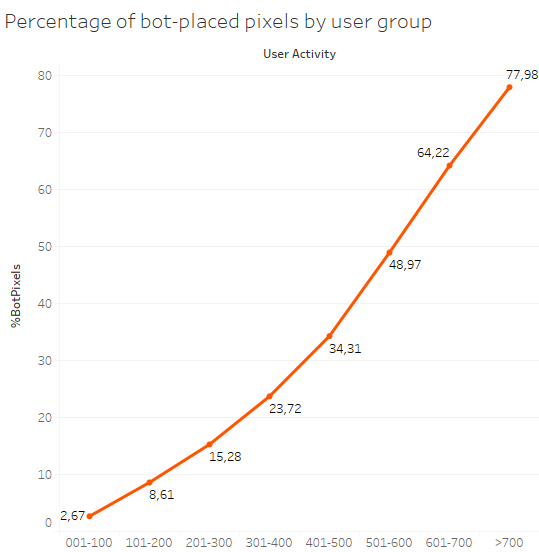 <br>

The percentages of pixels placed by scripts are not quite as high as one would expect for the higher ranges of activity, however this can be explained by the fact that accounts who did not verify their email had a 20 minute cooldown instead of a 5 minute one; furthermore, some users complained that they had variable cooldown times, from 10 minutes even up to 1 hour, likely because of programming errors of the r/place board. <br>
The >700 range having a 77% of botPixels indicates that they managed to place so many pixels only thanks to the 5 minute cooldown (verified accounts).<br>

Personally I thought the percentages of bot use would be overall higher because of the size and complexity of many pixel art pieces on the board, but thinking back on it installing and running a script is not easy or intuitive for most users; most pixel art was made manually (with help of an overlay) by communities who coordinated via discord or livestreams.

### Zoom-in on 1-100 range

As seen above, the vast majority of users placed less than 100 pixels; below the exploration focusing on this portion of users, by grouping them in ranges of 10 pixels placed.

In [16]:
userActivityRdd.
    join(botActivityRdd).
    map({
        case(usr, (nPixels, botPixels)) if nPixels > 100 => (">100", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 91 to 100 contains nPixels => ("91-100", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 81 to 90 contains nPixels => ("81-90", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 71 to 80 contains nPixels => ("71-80", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 61 to 70 contains nPixels => ("61-70", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 51 to 60 contains nPixels => ("51-60", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 41 to 50 contains nPixels => ("41-50", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 31 to 40 contains nPixels => ("31-40", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 21 to 30 contains nPixels => ("21-30", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 11 to 20 contains nPixels => ("11-20", (nPixels, botPixels, 1))
        case(usr, (nPixels, botPixels)) if 1 to 10 contains nPixels => ("01-10", (nPixels, botPixels, 1))
    }).
    reduceByKey((x1,x2)=>(x1._1+x2._1, x1._2+x2._2, x1._3+x2._3)).
    sortBy(_._1, true, 1).
    flatMap({case(range, (nPixels, botPixels, nUsr)) => Array((range, nPixels, botPixels, nUsr))}).
    toDF("userActivity", "nPixels", "botPixels", "numUsers").
    write.option("header", true).format("csv").mode(SaveMode.Overwrite).
    save("s3a://"+bucketname+"/spark/rplace/userAndBotActivity10s")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

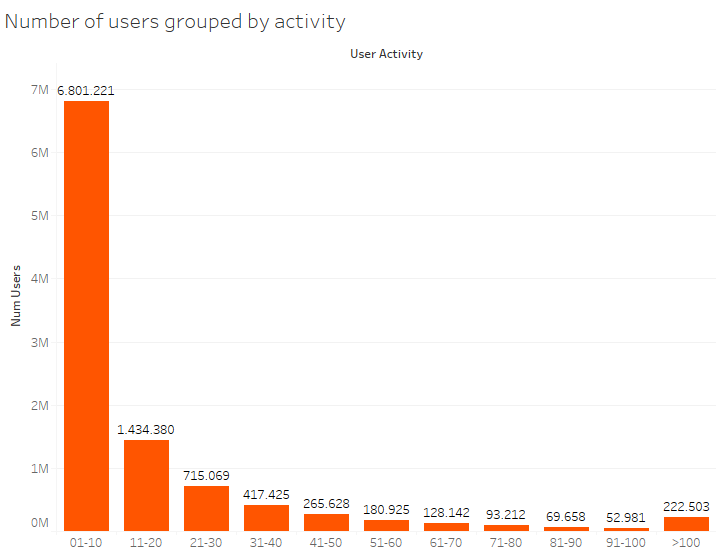<br>
Almost 7 million users placed less than 10 pixels (total distinct users: 10 million)<br>

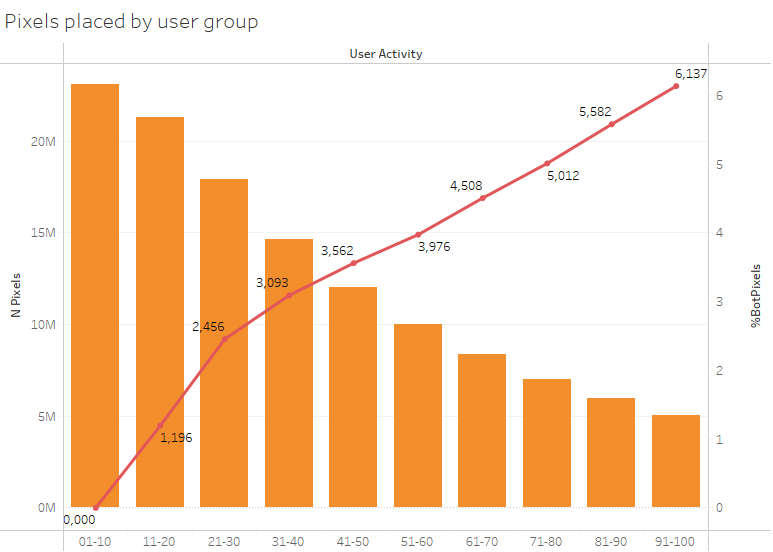

In [47]:
sc.getPersistentRDDs.foreach(_._2.unpersist())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…